In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *

In [3]:

PATH = Path("/home/paperspace/data/")
os.makedirs(PATH, exist_ok=True)

print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)

Quadro M4000


In [4]:
tfms = get_transforms(do_flip=False, p_lighting=0)

In [5]:
x = ImageItemList.from_folder(PATH).split_by_folder().label_from_folder()

In [6]:
data = (ImageItemList.from_folder(PATH)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats)) 

### conv_layer helper

In [7]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)
    )

In [8]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1 = conv_layer(ni, ni//2, ks=1)
        self.conv2 = conv_layer(ni//2, ni, ks=1)
        
    def forward(self, x):
        return x.add(self.conv2(self.conv1(x)))

In [9]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2, stride=stride)
               ] + [ResLayer(ch_in*2) for i in range(num_blocks)]
    
    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i, nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
            
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
        
    
    def forward(self, x): return self.layers(x)
        

In [10]:
m = Darknet([1,2,8,8,4], num_classes=7)

In [11]:
m = nn.DataParallel(m, device_ids=None)

In [12]:
lr = 0.1

In [13]:
data.batch_size = 16

In [14]:
data.batch_size

16

In [15]:
learner = Learner(data, m)
learner.crit = nn.CrossEntropyLoss()
learner.metrics = [accuracy]
wd=1e-4

In [16]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


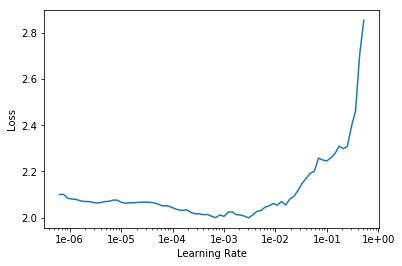

In [17]:
learner.recorder.plot()

In [18]:
%time learner.fit_one_cycle(cyc_len=30, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy
1,1.395303,2.466763,0.182927
2,1.224120,3.587547,0.302168
3,1.049757,17.057930,0.292683
4,0.993398,20.503506,0.298781
5,0.972171,4.446751,0.451219
6,0.898113,33.032421,0.161247
7,0.843697,3.750198,0.443089
8,0.698177,4.799253,0.474932
9,0.624221,5.150990,0.340786
10,0.575304,2.076023,0.586721


CPU times: user 34min 3s, sys: 16min 24s, total: 50min 28s
Wall time: 50min 42s


In [19]:
%time learner.fit_one_cycle(cyc_len=30, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy
1,0.255654,0.188302,0.926829
2,0.258440,0.486296,0.855014
3,0.266145,1.605713,0.754743
4,0.325055,2.939913,0.600949
5,0.356176,1.469167,0.764905
6,0.324073,0.961859,0.711382
7,0.410490,0.834606,0.813008
8,0.384190,4.624886,0.491192
9,0.396708,4.869090,0.630081
10,0.386215,8.365310,0.355014


CPU times: user 34min 9s, sys: 16min 29s, total: 50min 39s
Wall time: 50min 53s


In [21]:
log_preds,y = learner.TTA()

TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

In [22]:
# preds = np.mean(np.exp(log_preds),0, keepdims)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, keepdims=bool, axis=int, ), but expected one of:
 * ()
 * (torch.dtype dtype)
 * (tuple of ints dim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)


In [26]:
np

<module 'numpy' from '/home/paperspace/anaconda3/envs/fontastic/lib/python3.7/site-packages/numpy/__init__.py'>

In [29]:
np_log_preds = np.array(log_preds)

In [30]:
preds = np.argmax(np.exp(np_log_preds), axis=1)

In [38]:
from sklearn.metrics import confusion_matrix, f1_score

In [32]:
cm = confusion_matrix(y, preds)

In [40]:
f1_score(y, preds, average='micro')

0.9247967479674797

In [33]:
cm

array([[187,   0,  27,   0,   0,   1,   1],
       [  0,  94,   1,   0,   0,   0,   1],
       [  1,   0, 430,   0,   0,   1,   0],
       [  2,   0,  16,  96,   0,   2,   4],
       [  0,   0,   1,   0, 176,   1,   2],
       [  0,   0,  30,   0,   0, 186,   0],
       [  2,   0,  14,   1,   3,   0, 196]])

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figsize=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
data.train_ds.y.classes

['lato',
 'merriweather',
 'montserrat',
 'open-sans',
 'oswald',
 'raleway',
 'roboto']

[[187   0  27   0   0   1   1]
 [  0  94   1   0   0   0   1]
 [  1   0 430   0   0   1   0]
 [  2   0  16  96   0   2   4]
 [  0   0   1   0 176   1   2]
 [  0   0  30   0   0 186   0]
 [  2   0  14   1   3   0 196]]


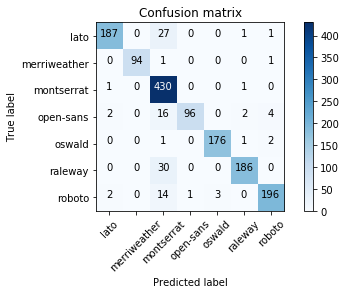

In [37]:
plot_confusion_matrix(cm,  data.train_ds.y.classes)

In [ ]:
log_preds.shape, preds.shape

In [ ]:
y.shape

In [40]:
preds = np.argmax(preds, axis=1)
# probs = probs[:,1]

In [41]:
cm = confusion_matrix(y, preds)

[[200   0   3   3   0   3   7]
 [  0  94   0   0   0   0   2]
 [  3   0 423   1   0   5   0]
 [  4   0   0 105   0   0  11]
 [  0   0   0   0 179   0   1]
 [  3   0  18   0   0 195   0]
 [  3   0   0   3   2   2 206]]


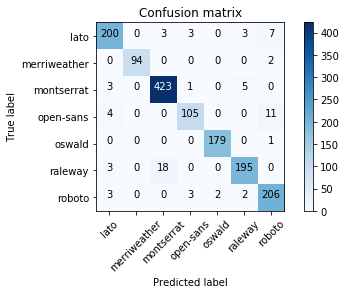

In [42]:
plot_confusion_matrix(cm, data.classes)